In [2]:
import os

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

In [6]:
llm.invoke("hello?")

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpFM9fl3FYWEx7i41SGSxhk4MD2CQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9613ebc4-41c5-44f5-985e-a05a06d21f02-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
### 
from langgraph.types import Command

In [8]:
### React Agent
from langgraph.prebuilt import create_react_agent

In [9]:
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     Name:str
#     age:int
#     DOB:int

In [10]:
def add_number(state):
    result = state["num1"] + state["num2"]
    print(f"Addition is:-  {result}")
    #working of Command
    #Uisng these command we will switch in multiple agents
    return Command(goto = "multiply",update = {"sum":result})


In [11]:
state = {"num1":10,"num2":20}

In [12]:
add_number(state)

Addition is:-  30


Command(update={'sum': 30}, goto='multiply')

### Creating one dummy multiagent

- it is for network/collab multiagent

In [13]:
from langchain_core.tools import tool

In [14]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [15]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [16]:
llm_with_tool = llm.bind_tools([transfer_to_addition_expert])

In [17]:
response = llm_with_tool.invoke("hi")

In [18]:
response.content

'Hello! How can I assist you today?'

In [19]:
response.tool_calls

[]

In [20]:
system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )


In [21]:
response = llm_with_tool.invoke("What is 2 multiply 2?")

In [22]:
response.content

''

In [23]:
response.tool_calls

[{'name': 'transfer_to_addition_expert',
  'args': {},
  'id': 'call_yIWdT3ufT05XoKvZeeobxvRc',
  'type': 'tool_call'}]

In [24]:
from typing_extensions import Literal 
from langgraph.graph import MessagesState,StateGraph,START,END

In [25]:
##Agent1
def additional_expert(state:MessagesState) -> Command[Literal["multiplication_expert","__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)

    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
            )
    
    return {"messages": [ai_msg]}
  

In [26]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [27]:
### State Graph
graph = StateGraph(MessagesState)
##Add the Node
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)
###Add Edges
graph.add_edge(START, "additional_expert")


In [28]:
#compile the Graph
app = graph.compile()

In [29]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='a48d87e7-9779-457b-90ca-4e6433df6094'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_H0X6pUDHHLHZoFn2R9c3TeI3', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpFMEYCSospCvsfQDcDZOfnxkKvVz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--348a57cf-c890-451a-8bcc-24c4dd0d4463-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}

In [30]:
for output in app.stream({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("----"*10)
        print(key,"<----here is key \n")
        print(value)
        print("\n")

here is output from additional_expert
----------------------------------------
additional_expert <----here is key 

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DY58kRgofgNM16v5u6Fjdw1b', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpFMH8yncDOQtPaPhzAmErGVg34k4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0ea078a9-8b3f-4ee5-bde3-356d3441e20e-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_DY58kRgofgNM16v5u6Fjdw1b', 

In [31]:
app.invoke({"messages":[("user","what's  1 * (10 +3). Provide me the output")]})

{'messages': [HumanMessage(content="what's  1 * (10 +3). Provide me the output", additional_kwargs={}, response_metadata={}, id='96b8c381-1c73-4d41-be3f-36adc0717916'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_G50XimL0Um5d4XE1fxOfwubA', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 85, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpFMJm7Q4boQaAAMcCphpbUMoLWJa', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a488a95d-6107-4ec6-b568-93e2ca28535c-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {},

In [32]:
for output in app.stream({"messages":[("user","what's  1 * (10 +3). Provide me the output")]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("----"*10)
        print(key,"<----here is key \n")
        print(value)
        print("\n")

here is output from additional_expert
----------------------------------------
additional_expert <----here is key 

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_M0bJyeTa7qdWXYnLadD2ijrO', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 85, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpFMM3VXs69CEkoBYm9Nn4d3kCixN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4ca84742-68a6-410a-ae27-426881ac2b64-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_M0bJyeTa7qdWXYnLadD2ijrO', '

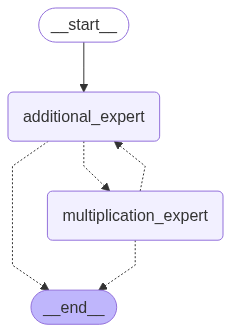

In [33]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## With realtime tool

In [34]:
from langchain_community.tools import DuckDuckGoSearchRun


In [35]:
# search_tool=DuckDuckGoSearchRun()

import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

C:\Users\Mohan\AppData\Local\Temp\ipykernel_25920\332319304.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


In [36]:
search_tool.invoke("who is a current pm of uk?")

[{'title': 'Prime Minister - GOV.UK',
  'url': 'https://www.gov.uk/government/ministers/prime-minister',
  'content': 'The Prime Minister is the leader of His Majesty’s Government and is ultimately responsible for the policy and decisions of the government.\n\nAs leader of the UK government the Prime Minister also:\n\n## Current role holder\n\n### The Rt Hon Sir Keir Starmer KCB KC MP\n\nSir Keir Starmer became Prime Minister on 5 July 2024.\n\n## Education',
  'score': 0.8235701},
 {'title': 'Prime Minister of the United Kingdom - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_the_United_Kingdom',
  'content': 'As of 2025 58 people (55 men and 3 ... Keir Starmer succeeded Rishi Sunak as prime minister on 5 July 2024, following the 2024 general election.',
  'score': 0.7672197},
 {'title': 'Keir Starmer - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Keir_Starmer',
  'content': 'Sir Keir Rodney Starmer (born 2 September 1962) is a British politician and law

In [37]:
! pip install langchain_experimental -q

In [38]:
from langchain_experimental.utilities import PythonREPL

In [39]:
repl = PythonREPL()

In [40]:
code = """
x = 5
y = x * 2
print(y)
"""

In [41]:
# repl.invoke() ##this is not a tool

In [42]:
from typing import Annotated

In [43]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Mohan\AppData\Local\Temp\ipykernel_25920\4065183586.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Mohan\AppData\Local\Temp\ipykernel_25920\4065183586.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [44]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x000002799C15F420>)

In [45]:
print(python_repl_tool.invoke(code))

Python REPL can execute arbitrary code. Use with caution.


Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [46]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [47]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [48]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [49]:
from langchain_core.messages import BaseMessage, HumanMessage

In [50]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [51]:
###Agent1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt = make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
    )
    
    result = research_agent.invoke(state)
    
    # result = [messages:{humanmesssage
    #                 aimessgae
    #                 toolmessage
    #                 aimessage
    #                 toolmessage
    #                 aimessage}
    #                 ]
    
    goto = get_next_node(result["messages"][-1],"chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [52]:
## agent1(human1)-->agent2(human2)

In [53]:
###Agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent = create_react_agent(
        llm,
        tools = [python_repl_tool],
        prompt = make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content = result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [54]:
### Workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
#compile
app = workflow.compile()

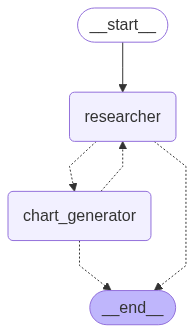

In [55]:
workflow.compile()

In [ ]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

In [56]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='24c2d2e2-f9ea-4ef1-a166-9b22654bb8fd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NOB64t62asbxVs6IQD5ByhPC', 'function': {'arguments': '{"query":"UK GDP by year"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 209, 'total_tokens': 230, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BpFMvtWlMSLGNA32hZ7Oy7b157yMc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6ce7111c-7a4f-4a49-9e71-10f03c43

In [57]:
code="""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()"""

In [58]:
print("""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()""")

import matplotlib.pyplot as plt\n\n# Data for the UK GDP over the past 3 years\nyears = [2019, 2020, 2021]\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \n\ndef create_line_chart(years, gdp_values):\n    plt.figure(figsize=(10, 6))\n    plt.plot(years, gdp_values, marker='o', color='b', linestyle='-', linewidth=2)\n    plt.title('UK GDP Over the Past 3 Years')\n    plt.xlabel('Year')\n    plt.ylabel('GDP (in billion $)')\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()
